### Importing Libraries


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, precision_score, recall_score, ndcg_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

import warnings
warnings.filterwarnings('ignore')

### Prepare DataSet


In [ ]:
df = pd.read_csv("spotify_dataset.csv")

df.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [62]:
df_main = pd.read_csv("spotify_dataset.csv")

In [3]:
drop_cols = ['track_id', 'track_name', 'track_artist', 'track_album_id', 
            'track_album_name', 'track_album_release_date', 'playlist_id']
df.drop(columns=drop_cols, inplace=True)

assert df.isnull().sum().sum() == 0, "There are missing values. Handle them."

In [4]:
df['playlist_genre'] = df['playlist_genre'].astype('category').cat.codes
df['playlist_subgenre'] = df['playlist_subgenre'].astype('category').cat.codes

In [5]:
df_meta = df.copy()

X = df.drop(['playlist_name'], axis=1)
print("Preprocessing done. Shape:", X.shape)

Preprocessing done. Shape: (32833, 15)


### EDA


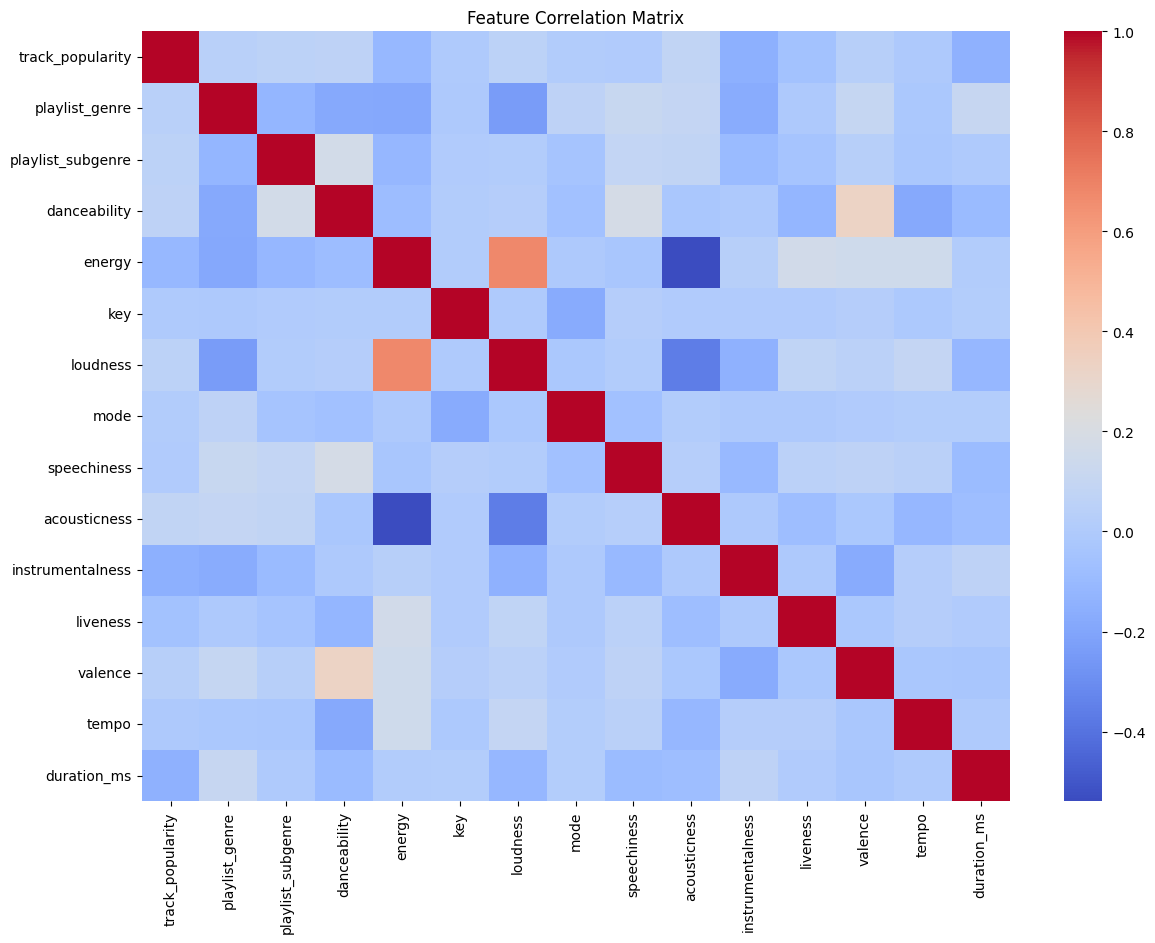

In [6]:
plt.figure(figsize=(14,10))
sns.heatmap(X.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

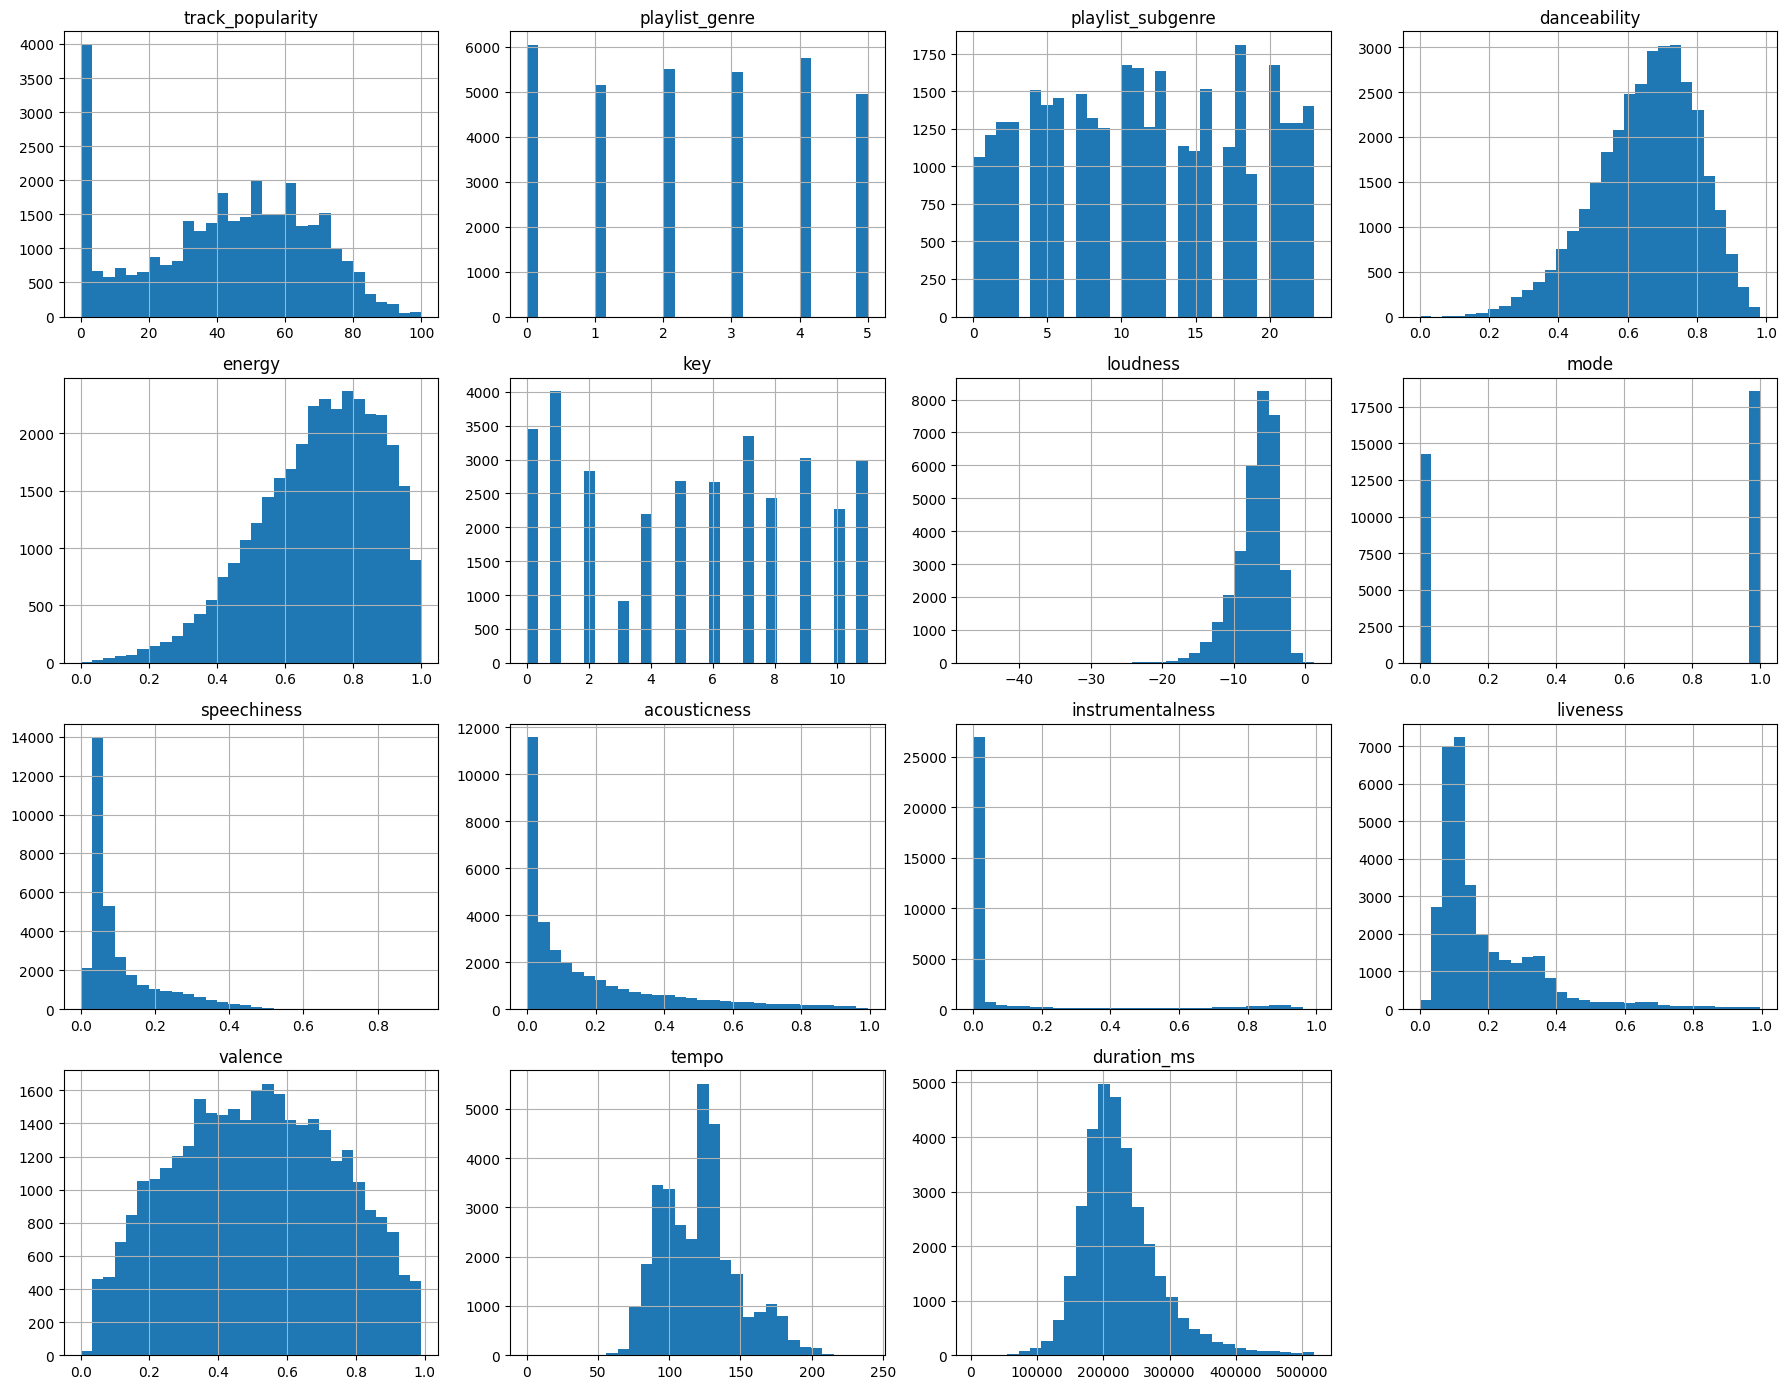

In [7]:
X.hist(figsize=(18, 14), bins=30)
plt.tight_layout()
plt.show()

In [8]:
print(X.describe())

       track_popularity  playlist_genre  playlist_subgenre  danceability  \
count      32833.000000    32833.000000       32833.000000  32833.000000   
mean          42.477081        2.442695          11.601651      0.654850   
std           24.984074        1.708774           6.794586      0.145085   
min            0.000000        0.000000           0.000000      0.000000   
25%           24.000000        1.000000           6.000000      0.563000   
50%           45.000000        2.000000          11.000000      0.672000   
75%           62.000000        4.000000          18.000000      0.761000   
max          100.000000        5.000000          23.000000      0.983000   

             energy           key      loudness          mode   speechiness  \
count  32833.000000  32833.000000  32833.000000  32833.000000  32833.000000   
mean       0.698619      5.374471     -6.719499      0.565711      0.107068   
std        0.180910      3.611657      2.988436      0.495671      0.101314   

### Outlier Removal + Scaling


In [9]:
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [10]:
X_clean = remove_outliers(X)
print("Outliers removed. New shape:", X_clean.shape)

Outliers removed. New shape: (19226, 15)


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

### PCA


In [12]:
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df_meta = df_meta.iloc[:X_scaled.shape[0]].reset_index(drop=True)

print(f"PCA done. Reduced from {X.shape[1]} to {X_pca.shape[1]} features.")

PCA done. Reduced from 15 to 13 features.


### K-Means Clustering


In [13]:
inertia = []
silhouette_scores = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, labels))

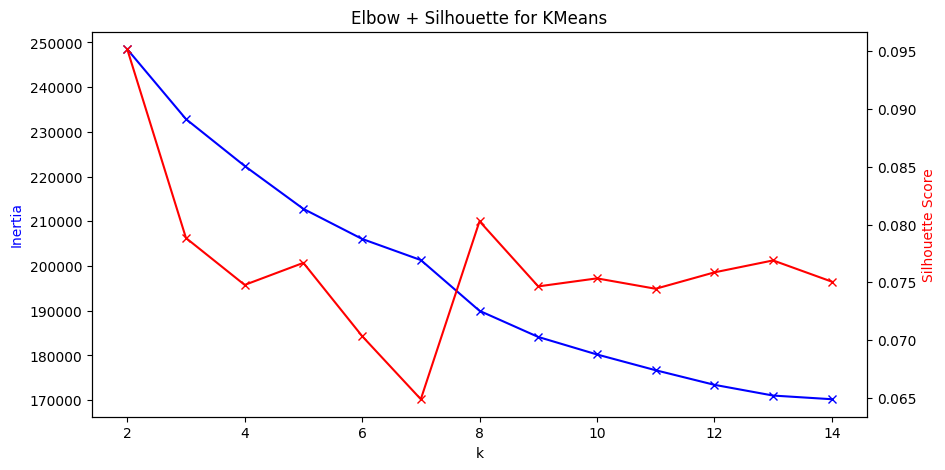

In [14]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(k_range, inertia, 'bx-', label='Inertia')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia', color='b')
ax2 = ax1.twinx()
ax2.plot(k_range, silhouette_scores, 'rx-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')
plt.title('Elbow + Silhouette for KMeans')
plt.show()

In [15]:
best_k = k_range[np.argmax(silhouette_scores)]
print("Best k:", best_k)

Best k: 2


In [16]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

### Agglomerative Clustering


In [17]:
agg = AgglomerativeClustering(n_clusters=best_k)
agg_labels = agg.fit_predict(X_pca)

print("Agglomerative Clustering Silhouette:", silhouette_score(X_pca, agg_labels))
print("KMeans Clustering Silhouette:", silhouette_score(X_pca, cluster_labels))

Agglomerative Clustering Silhouette: 0.2047135659615619
KMeans Clustering Silhouette: 0.09517857901711016


### Autoencoder Embedding


In [18]:
input_dim = X_scaled.shape[1]
encoding_dim = 10

In [19]:
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
bottleneck = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(bottleneck)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, bottleneck)

In [28]:
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0710 - val_loss: 0.1062
Epoch 2/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0671 - val_loss: 0.1028
Epoch 3/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0675 - val_loss: 0.1108
Epoch 4/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0673 - val_loss: 0.1098
Epoch 5/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0676 - val_loss: 0.1089
Epoch 6/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0666 - val_loss: 0.1033
Epoch 7/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0670 - val_loss: 0.1060
Epoch 8/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0676 - val_loss: 0.1078
Epoch 9/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0674 - val_loss: 0.1009
Epoch 10/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0663 - val_loss: 0.1007
Epoch 11/100
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0667 - val_loss: 0.1099
Epoch 12/100
241/241 ━━━━━━━━━━━━━━━━━━━━

In [29]:
X_embedded = encoder.predict(X_scaled)

601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


In [30]:
kmeans_embed = KMeans(n_clusters=best_k, random_state=42)
embed_labels = kmeans_embed.fit_predict(X_embedded)

In [31]:
print("Autoencoder Embedding Silhouette:", silhouette_score(X_embedded, embed_labels))

Autoencoder Embedding Silhouette: 0.40651515


### Recommendation System


In [ ]:
def hybrid_recommend(song_index, top_n=5):
    song_vector = X_scaled[song_index].reshape(1, -1)
    similarities = cosine_similarity(song_vector, X_scaled).flatten()

    pop_boost = df_meta['track_popularity'].values / 100
    scores = similarities * 0.7 + pop_boost * 0.3

    recommended_indices = scores.argsort()[::-1][1:top_n+1]

    return df_main.iloc[recommended_indices][['track_name', 'track_artist', 'track_popularity', 'playlist_genre']]

In [64]:
hybrid_recommend(10, top_n=5)

,track_name,track_artist,track_popularity,playlist_genre
10,Cross Me (feat. Chance the Rapper & PnB Rock) ...,Ed Sheeran,58,pop
2655,Happy Now,Zedd,80,pop
233,Carry On - Nicky Romero Remix,Kygo,67,pop
81,What I Like About You (feat. Theresa Rex),Jonas Blue,81,pop
2666,Better When You're Gone,David Guetta,76,pop


### Playlist Generation


In [ ]:
def generate_playlist(seed_song_index, playlist_length=15):
    playlist = []
    current_song = seed_song_index

    for _ in range(playlist_length):
        playlist.append(current_song)

        song_vector = X_scaled[current_song].reshape(1, -1)
        similarities = cosine_similarity(song_vector, X_scaled).flatten()

        pop_boost = df_meta['track_popularity'].values / 100
        scores = similarities * 0.7 + pop_boost * 0.3

        scores[playlist] = -1  

        next_song = np.argmax(scores)
        current_song = next_song

    return df_main.iloc[playlist][['track_name', 'track_artist', 'track_popularity', 'playlist_genre']]

In [66]:
generate_playlist(seed_song_index=10, playlist_length=15)

,track_name,track_artist,track_popularity,playlist_genre
10,Cross Me (feat. Chance the Rapper & PnB Rock) ...,Ed Sheeran,58,pop
95,The Middle,Zedd,84,pop
2078,La La Land,Demi Lovato,59,pop
3302,Show Me Love - EDX Remix / Radio Edit,Sam Feldt,67,pop
19120,Patek,Ozuna,75,latin
17467,Closer (feat. Halsey),The Chainsmokers,85,latin
18309,Rare,Selena Gomez,88,latin
18766,Adicto (with Anuel AA & Ozuna),Tainy,90,latin
18302,Good News,Mac Miller,87,latin
18307,Blinding Lights,The Weeknd,98,latin
